# Understanding cloud organization from satellite
Climate change has been at the top of our minds and on the forefront of important political decision-making for many years.

Shallow clouds play a huge role in determining the Earth's climate. They’re also difficult to understand and to represent in climate models. By classifying different types of cloud organization, researchers at Max Planck hope to improve our physical understanding of these clouds, which in turn will help us build better climate models.

To know more about the dataset, please visit: https://www.kaggle.com/c/understanding_cloud_organization




## 1. IMPORT LIBRARIES AND DATASETS


### 1.1 Import the datasets - Kaggle API

We would use kaggle API to download our datasets. Here is a list of works we need to do:
- Install and kaggle libraries in python.
- Export kaggle username and key.
- Download the datasets.

In [3]:
!kaggle competitions download -c understanding_cloud_organization

100%|██████████████████████████████████████▉| 5.79G/5.80G [01:29<00:00, 161MB/s]
100%|██████████████████████████████████████| 5.80G/5.80G [01:31<00:00, 67.9MB/s]


### 1.2 Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches as patches
import tensorflow as tf
import os 
import seaborn as sns
import pathlib
import random
import cv2

# import YOLOV4
%matplotlib inline

### 1.3 Locate the datasets



In [3]:
train_path = './data/train/train_images'
test_path = './data/test/test_images'
clean_path = './data/train/clean_images'

train_data_path = [os.path.join(train_path, file_name) for file_name in os.listdir(train_path)]

In [4]:
train_data_path[:5]

['./data/train/train_images/dba3b3c.jpg',
 './data/train/train_images/e5ec2d9.jpg',
 './data/train/train_images/a5931e4.jpg',
 './data/train/train_images/0a709e6.jpg',
 './data/train/train_images/55a90df.jpg']

## 2. Explore the dataset


Convert the csv file into a DataFrame named `df`. This `df` has 2 columns: `Image_Label` and `EncodedPixels`
- `Image_Label` contains both image's name and label of cloud-organization that image has.
- `EncodedPixels` contains info about pixels where that cloud-organization's in. These pixels are encoded by RLE *(run-length encoding)*.

For more information about RLE: [Wiki](https://en.wikipedia.org/wiki/Run-length_encoding)

In [5]:
df = pd.read_csv('./data/train/train.csv')
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...



Becasuse the `Image_Label` column contain both about image's name and its label. So at first, we try to split them into 2 new columns: `image` contains image's name and `label` contains its label.

In [6]:
df['label'] = df['Image_Label'].apply(lambda x: x.split('_')[1] + ' ')
df['image'] = df['Image_Label'].apply(lambda x: x.split('_')[0])

In [7]:
df.head()

,Image_Label,EncodedPixels,label,image
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


List all of unique label and number of it's occurence in datasets. Seems like this dataset is quite balanced between each label. It's a good news!

In [8]:
df.groupby('label')['EncodedPixels'].count()

label
Fish       2781
Flower     2365
Gravel     2939
Sugar      3751
Name: EncodedPixels, dtype: int64

 We can easily realize that an image could have more than one label. And it would be hard for us if let the image's name duplicated in `image` column. So we have to group all the dataset by image's name before continuing:

In [9]:
# This code would drop all NaN rows, which means that image doesn't contain that cloud-organization.
# Then, it would reassign the EncodedPixels column by a new tulpe (label, EncondedPixels) for next few steps.
df['EncodedPixels'] = df.dropna(axis =0).apply(lambda row: (row['label'], row['EncodedPixels']), axis =1)

In [10]:
# Group all the dataset after remove NaN values by image's name and sum all the label (in this case, sum() will means add a new string to the current one)
df1 = df.dropna(axis =0).groupby('image')['label'].sum()

In [11]:
df1 = df1.reset_index()
df1.head()

,image,label
0,0011165.jpg,Fish Flower
1,002be4f.jpg,Fish Flower Sugar
2,0031ae9.jpg,Fish Flower Sugar
3,0035239.jpg,Flower Gravel
4,003994e.jpg,Fish Gravel Sugar


Here, we need to convert all the label of an image into one-hot coding for computer could learn from it. And now our problem will become a **multi-class binary classification problem**.

In [12]:
# Use str.get_dummies to get one-hot coding based on its label and concatanate with the origin DataFrame
one_hot = df1['label'].str.get_dummies(sep = ' ')
df1 = pd.concat([df1, one_hot], axis = 1)
df1.head()

,image,label,Fish,Flower,Gravel,Sugar
0,0011165.jpg,Fish Flower,1,1,0,0
1,002be4f.jpg,Fish Flower Sugar,1,1,0,1
2,0031ae9.jpg,Fish Flower Sugar,1,1,0,1
3,0035239.jpg,Flower Gravel,0,1,1,0
4,003994e.jpg,Fish Gravel Sugar,1,0,1,1


In [13]:
# Add one more column contain the list of tuples
a = df.dropna(axis =0).groupby('image')['EncodedPixels'].apply(list).reset_index()
df1['encoded'] = a['EncodedPixels']

# And here is our whole dataset for preprocessing and training models
df1.head()

,image,label,Fish,Flower,Gravel,Sugar,encoded
0,0011165.jpg,Fish Flower,1,1,0,0,"[(Fish , 264918 937 266318 937 267718 937 2691..."
1,002be4f.jpg,Fish Flower Sugar,1,1,0,1,"[(Fish , 233813 878 235213 878 236613 878 2380..."
2,0031ae9.jpg,Fish Flower Sugar,1,1,0,1,"[(Fish , 3510 690 4910 690 6310 690 7710 690 9..."
3,0035239.jpg,Flower Gravel,0,1,1,0,"[(Flower , 100812 462 102212 462 103612 462 10..."
4,003994e.jpg,Fish Gravel Sugar,1,0,1,1,"[(Fish , 2367966 18 2367985 2 2367993 8 236800..."


The heatmap of correlation between pairs of label shows that each label seems independent to others.

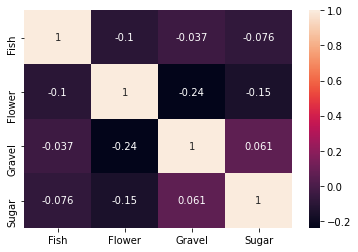

In [14]:
sns.heatmap(df1.corr(), annot = True)

Let's plot some sample images:

In [15]:
# This function would get a random sample of images from train folder or test folder and show them
def get_sample_image(n, data = 'train'):
    plt.rc('axes', grid=False)
    _, ax = plt.subplots(5, 4, sharex = 'col', sharey = 'row', figsize = (15, 20))
    ax = ax.ravel()
    if data == 'train':
        img_path = train_path
    elif data == 'test':
        img_path = test_path
        
    s = random.sample(range(len(df1)), n)
    for i, k in enumerate(s):
        image = mpimg.imread(os.path.join(img_path, df1['image'].iloc[k]))
        ax[i].imshow(image)
        ax[i].set_title('{} - {}'.format(df1['image'].iloc[k], df1['label'].iloc[k]))
    plt.show()

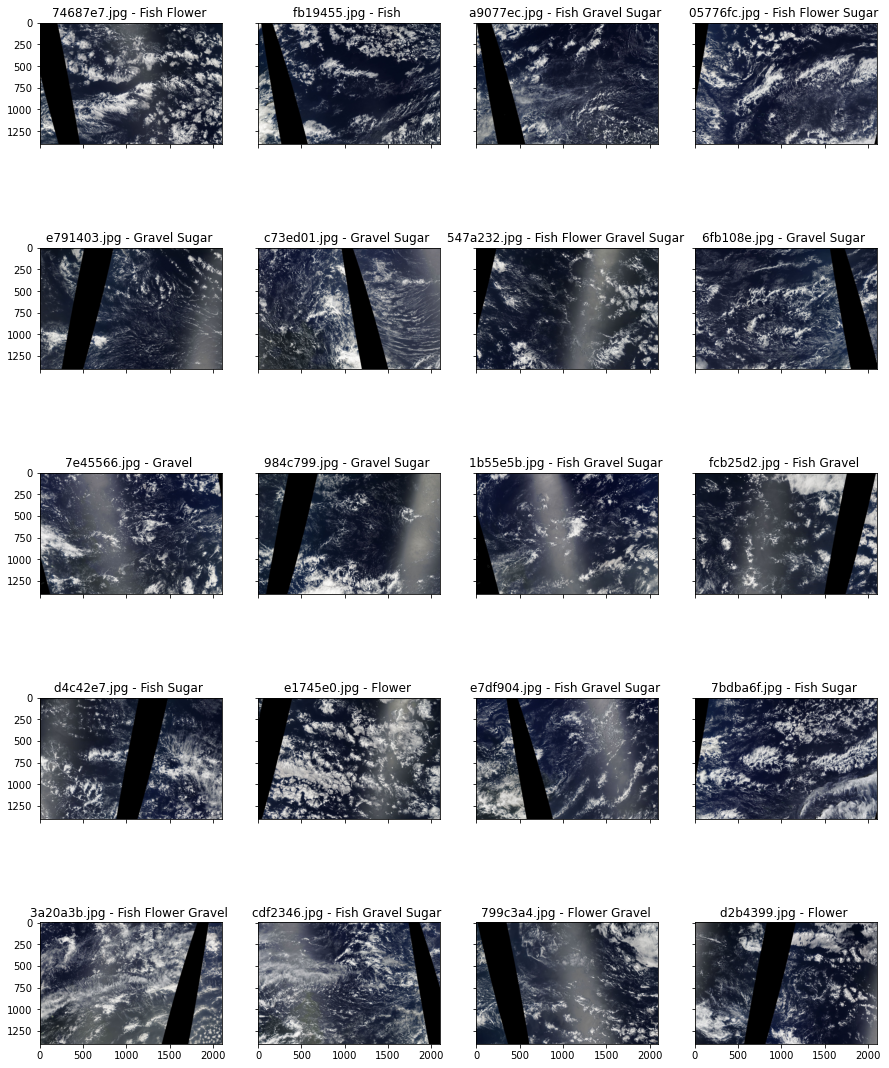

In [16]:
get_sample_image(20)

One more step to easier exploring the shape of each label is drawing the bounding box

First, we need to create a sub dataframe `df_set` from our current dataframe `df1` and set the image name as index to use `enumerate()` later.

In [17]:
df_set = df1.set_index('image')['encoded']

In [18]:
df_set

image
0011165.jpg    [(Fish , 264918 937 266318 937 267718 937 2691...
002be4f.jpg    [(Fish , 233813 878 235213 878 236613 878 2380...
0031ae9.jpg    [(Fish , 3510 690 4910 690 6310 690 7710 690 9...
0035239.jpg    [(Flower , 100812 462 102212 462 103612 462 10...
003994e.jpg    [(Fish , 2367966 18 2367985 2 2367993 8 236800...
                                     ...                        
ffcedf2.jpg    [(Fish , 12631 4 12638 3 12649 16 13377 8 1339...
ffd11b6.jpg    [(Flower , 425921 5 425929 4 425945 2 425949 1...
ffd3dfb.jpg    [(Sugar , 12891 428 14291 428 15691 428 17091 ...
ffd6680.jpg    [(Flower , 1509467 305 1509773 7 1509782 2 151...
ffea4f4.jpg    [(Flower , 1194860 675 1196260 675 1197660 675...
Name: encoded, Length: 5546, dtype: object

Then, we need to define some functions for drawing the bounding boxes

In [19]:
# Define function to create a bounding box to mark the area of labeled cloud-organization.
def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

# Define function to decode from RLE to numpy array.
def rle_to_mask(rle_string, height, width):
    '''
    This function is used to decode from RLE to numpy array
    Input: RLE format
    Output: a numpy array 
    '''
    rows, cols = height, width

    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows * cols, dtype = np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index: index+ length] = 1
        img = img.reshape(cols, rows)
        img = img.T
        return img

# Define function to plot the image and its bounding boxes
def plot_cloud(img_path, img_id, label_mask):
    '''
    Read image with opencv and show in two columns.  
    First, shows the different types of cloud formation with a bounding box. 
    On the second column, we visualize the cloud picture with the mask segments as an overlay.
    '''
    # Read an image with opencv
    img = cv2.imread(os.path.join(img_path, img_id))
    
    # Setup the figure to plot image and colors of bounding box based on labels.
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))
    ax[0].imshow(img)
    ax[1].imshow(img)
    cmaps = {'Fish ': 'Blues', 'Flower ': 'Reds', 'Gravel ': 'Greys', 'Sugar ':'Purples'}
    colors = {'Fish ': 'Blue', 'Flower ': 'Red', 'Gravel ': 'Gray', 'Sugar ':'Purple'}
    
    # we use a for loop to plot every bounding box exist in each of image
    for label_mask_img in label_mask:
            label, mask = label_mask_img
            mask_decoded = rle_to_mask(mask, img.shape[0], img.shape[1])
            if mask != -1:
                rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
                bbox = patches.Rectangle((cmin,rmin), cmax - cmin, rmax - rmin, linewidth=1, edgecolor= colors[label], facecolor='none')
                ax[0].add_patch(bbox)
                ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=colors[label]))
                ax[1].imshow(img[rmin:rmax, cmin:cmax], alpha=0.3, cmap=cmaps[label])
                ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=colors[label]))

Crop each bounding box and save it as a new image with label

In [70]:
for image_id, label_mask in df_set.iteritems():
    img = cv2.imread(os.path.join(train_path, image_id))
    for label_mask_img in label_mask:
        label, mask = label_mask_img
        mask_decoded = rle_to_mask(mask, img.shape[0], img.shape[1])
        if mask != -1:
            rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
            cv2.imwrite(os.path.join(clean_path, image_id + '_' + label), img[rmin:rmax, cmin:cmax])

In [20]:
import glob

l = [x for x in os.listdir(clean_path)]
df_clean = pd.DataFrame(l, columns = ['image_path'])
df_clean['label'] = df_clean['image_path'].apply(lambda x: x.split('_')[-1].strip())

In [37]:
label_dict = {'Sugar': 0, 'Gravel': 1, 'Flower': 2, 'Fish': 3}
df_clean['label'] = df_clean['label'].apply(lambda x: label_dict[x])
df_clean

,image_path,label
0,b9c0279.jpg_Sugar,0
1,33b39e2.jpg_Gravel,1
2,055ebcb.jpg_Flower,2
3,5fbed06.jpg_Flower,2
4,de622ff.jpg_Flower,2
...,...,...
11831,7c5e584.jpg_Fish,3
11832,32b8e00.jpg_Gravel,1
11833,f954bde.jpg_Flower,2
11834,bdd2fe5.jpg_Sugar,0


Let's plot some random images with it's labels:

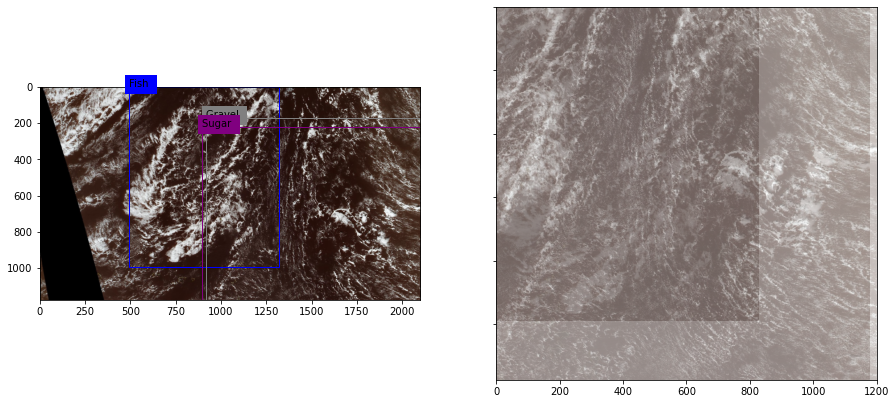

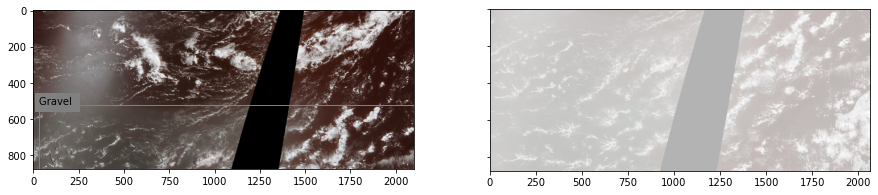

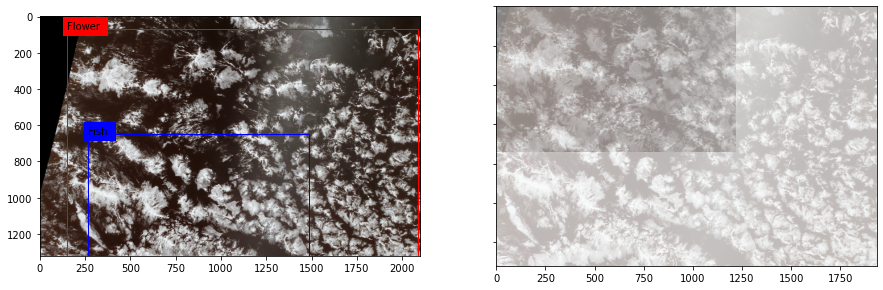

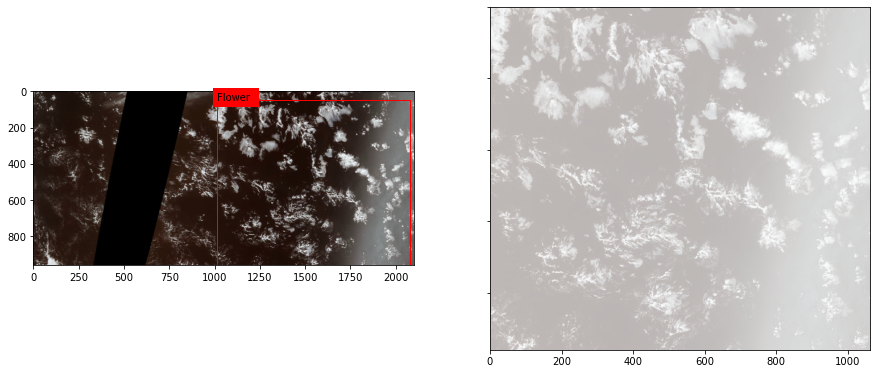

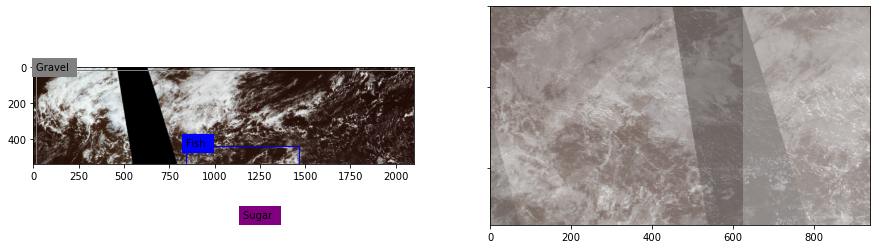

In [64]:
for image_id, label_mask in df_set.sample(5).iteritems():
    plot_cloud(train_path, image_id, label_mask)

Now, it's a bad news. <br/>
We can see that there are some overlapped in multi-label images, which would make our model be hard to classify the cloud-organization.

In [31]:
## plot some image with different label and their area in image

## extract the area of cloud and change to a new image maybe a better training

## BUILD a baseline model from one-hot coding label (sigmoid for multiclass label with one-hot coding) - would be bad predict 

## 3. Preprocessing data 

In [38]:
# Build a baseline model with one-hot coding label
from tensorflow.keras import layers, optimizers, models
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.experimental.AUTOTUNE
CHANNELS = 3
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
SHUFFLE_SIZE = 512

In [39]:
def augmentation(image, label):
    '''
    Augment image with some random adjust to each image.
    '''
    image = tf.image.random_brightness(image, .2)
    image = tf.image.random_contrast(image, lower = 0, upper = 0.5)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # try to zoom in, out
    return image, label


def preprocess_image(path, label):
    '''
    Read image from path resize, normalization, standardization image and set them as the input of augmentation()
    '''
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = CHANNELS)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image /= 255.0
    image = tf.image.per_image_standardization(image)
    return augmentation(image, label)

In [40]:
# image_path = df1['image'].apply(lambda x: os.path.join(train_path, x))
# image_label = df1[df1.columns[2:6]].to_numpy()

image_path = df_clean['image_path'].apply(lambda x: os.path.join(clean_path, x))
image_label = df_clean['label'].to_numpy()

In [41]:
# dataset = tf.data.Dataset.from_tensor_slices((image_path, image_label))
# dataset = dataset.map(preprocess_image, num_parallel_calls = AUTOTUNE)

Split the dataset into 3 parts: train_set, val_set and test_set

In [56]:
train_set_path, test_set_path, train_label, test_label = train_test_split(image_path, image_label, test_size = 0.2, random_state = 102)
train_set_path, val_set_path, train_label, val_label = train_test_split(train_set_path, train_label, test_size = 0.2, random_state = 102)

In [57]:
# Get the size of each dataset
TRAIN_SIZE = len(train_label)
VAL_SIZE = len(val_label)
TEST_SIZE = len(test_label)

Create and preprocess image for training. We use `map()` to preprocessing for each image in dataset

In [58]:
# Create train set, validation set and test set via tf.data.Dataset.from_tensor_slices
train_set = tf.data.Dataset.from_tensor_slices((train_set_path, train_label))
val_set = tf.data.Dataset.from_tensor_slices((val_set_path, val_label))
test_set = tf.data.Dataset.from_tensor_slices((test_set_path, test_label))

# Use map() for preprocessing and augmentation image in each dataset
train_set = train_set.map(preprocess_image, num_parallel_calls = AUTOTUNE)
val_set = val_set.map(preprocess_image, num_parallel_calls = AUTOTUNE)
test_set = test_set.map(preprocess_image, num_parallel_calls = AUTOTUNE)

In [59]:
# dataset = dataset.cache().repeat().shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

# Shuffle image and split them into many BATCH_SIZE batches 
train_set = train_set.repeat().shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
val_set = val_set.repeat().shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
test_set = test_set.repeat().shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

## 4. Building model

In [60]:
# dataset = tf.data.Dataset.from_tensor_slices((image_path, image_label))
# dataset = dataset.map(preprocess_image, num_parallel_calls = AUTOTUNE)

We use EarlyStopping and ModelCheckpoint to optimize the training process.

In [61]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                     mode = 'min',
                                     restore_best_weights = True,
                                     min_delta = 1e-5,
                                     verbose= 1,
                                     patience=10)

cp_path = os.path.join('./', 'cloud_cp_ResNet50.h5')
cp_dir = os.path.dirname(cp_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= cp_path,
                                                save_best_only= True,
                                                save_weights_only= True,
                                                monitor= 'val_loss',
                                                verbose = 1)

In [62]:
len(tf.keras.applications.ResNet50V2().layers)
# tf.keras.applications.ResNet50V2().summary()

192

In [63]:
# Set the number of freeze layers of model
fine_tune = 193

We used a pre-trained model called ResNet50V2.

In [64]:
def get_model():
    # We will build a Sequential model based on baseline model called ResNet50V2 with the additional output layers
    tf_model = tf.keras.applications.ResNet50V2(weights= 'imagenet', include_top = False, input_shape= (IMG_WIDTH, IMG_HEIGHT, CHANNELS))
    
    # Freeze bottom layers in ResNet50V2:
    for layer in tf_model.layers[:fine_tune]:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        tf_model,
        layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu'),
        layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
        
        layers.Dense(2048, activation = 'relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation = 'relu'),
        layers.Flatten(),
        layers.Dense(4, activation = 'softmax'),
    ])
    
    return model

model = get_model()

In [65]:
# model.summary()

In [66]:
# Compile with Adam optimizer, binary_crossentropy to calculuate loss function and accuracy to evaluate model
model.compile(tf.keras.optimizers.Adam(lr = 1e-4, decay = 5e-6), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [67]:
history = model.fit(train_set, steps_per_epoch= tf.math.ceil(float(TRAIN_SIZE/ BATCH_SIZE)),
                   epochs= 30,
                   validation_data= val_set,
                   validation_steps= tf.math.ceil(float(VAL_SIZE/ BATCH_SIZE)),
                   callbacks= [cp_callback, es])

Epoch 1/30
237/237 [==============================] - ETA: 0s - loss: 0.9798 - acc: 0.5723
Epoch 00001: val_loss improved from inf to 0.87317, saving model to ./cloud_cp_ResNet50.h5
237/237 [==============================] - 38s 162ms/step - loss: 0.9798 - acc: 0.5723 - val_loss: 0.8732 - val_acc: 0.6490
Epoch 2/30
237/237 [==============================] - ETA: 0s - loss: 0.8364 - acc: 0.6564
Epoch 00002: val_loss improved from 0.87317 to 0.79488, saving model to ./cloud_cp_ResNet50.h5
237/237 [==============================] - 38s 158ms/step - loss: 0.8364 - acc: 0.6564 - val_loss: 0.7949 - val_acc: 0.6729
Epoch 3/30
237/237 [==============================] - ETA: 0s - loss: 0.7897 - acc: 0.6762
Epoch 00003: val_loss did not improve from 0.79488
237/237 [==============================] - 37s 156ms/step - loss: 0.7897 - acc: 0.6762 - val_loss: 0.8010 - val_acc: 0.6693
Epoch 4/30
237/237 [==============================] - ETA: 0s - loss: 0.7675 - acc: 0.6860
Epoch 00004: val_loss impro

In [68]:
# Define a function to visualize train loss/val_loss and train_acc/val_acc per epochs
def plot_history(history, key='loss'):
    plt.figure(figsize=(12,8))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

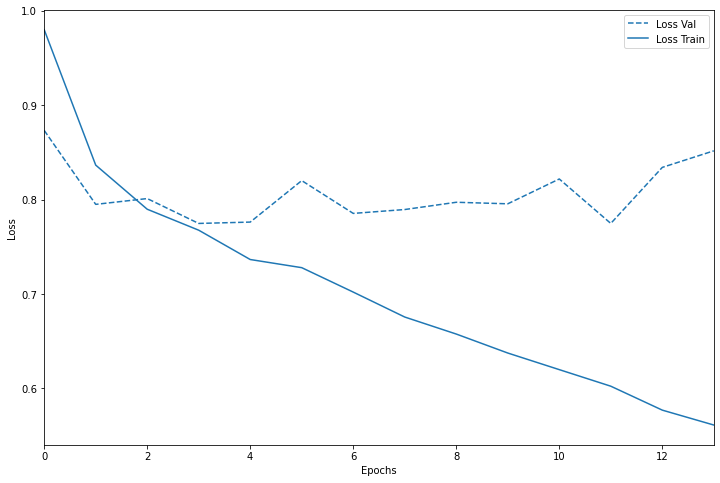

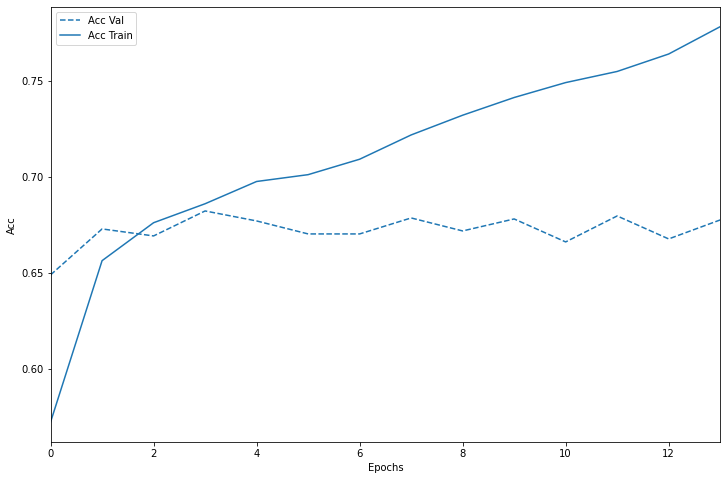

In [69]:
plot_history(history)
plot_history(history, key = 'acc')

In [70]:
model.evaluate(test_set, steps = tf.math.ceil(float(TEST_SIZE/ BATCH_SIZE)))

74/74 [==============================] - 9s 115ms/step - loss: 0.7647 - acc: 0.6871


[0.764660120010376, 0.6870777010917664]

In [ ]:
def preprocess_test(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image /= 255.0
    image = tf.expand_dims(image, axis = 0)
    return image

def predict(path):
    image = preprocess_test(path)
    results = model.predict(image)
    pred_tag = []
    
    for i in range(len(results[0])):
        prob = results[0][i]
        # The threshold level now is same for all label (0.5)
        if prob > 0.5:
            pred_tag.append(1)
        else:
            pred_tag.append(0)
    
    
    return pred_tag

In [ ]:
# for e in test_set.as_numpy_iterator():
    

In [ ]:
# random = np.random.choice(3698)

# df_test = pd.read_csv('../data/sample_submission.csv')
# df_test['image'] = df_test['Image_Label'].apply(lambda x: x.split('_')[0])
# df_test['label'] = df_test['Image_Label'].apply(lambda x: x.split('_')[1])

In [ ]:
# df_test.head()

In [ ]:
# df_test['EncodedPixels'].unique()

In [ ]:
# df_test['label'] = df_test['label'].apply(lambda x: x + ' ')
# df_test1 = df_test.dropna(axis = 0).groupby('image')['label'].apply(list).reset_index()

In [ ]:
# plt.rc('axes', grid=False)
# _, ax = plt.subplots(figsize = (15, 20))
# # ax = ax.ravel()

# image = mpimg.imread(os.path.join(test_path, df_test1['image'].iloc[0]))
# ax.imshow(image)
# ax.set_title('{} - {}'.format(df_test1['image'].iloc[0], df_test1['label'].iloc[0]))
# plt.show()

In [ ]:
# df_test['EncodedPixels'] = df_test.apply(lambda row: (row['label'], row['EncodedPixels']), axis = 1)

In [ ]:
# df_test_plot = df_test.groupby('image')['EncodedPixels'].apply(list)

In [ ]:
# for image_id, label_mask in df_test_plot.sample(10).iteritems():
#     plot_cloud(test_path, image_id, label_mask)